In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from opencage.geocoder import OpenCageGeocode
import folium

In [2]:
df = pd.DataFrame(pd.read_csv("../assets/normalized_pyramid_data.csv"))

In [4]:
key = ['unknown', 'pyramid?']
complexes = df[~df['pyramid_complex'].isin(key)]
kings_and_queens = complexes.groupby(['pyramid_complex', 'royal_status'], sort=False).size().reset_index(name='count')

confirmed_count_fig = px.bar(kings_and_queens, 
             x='pyramid_complex', 
             y='count', 
             color='royal_status',
             title='Number of Confirmed Pyramids At Each Complex',
             labels={
                 'pyramid_complex': 'Pyramid Complex',
                 'count': 'Number of Pyramids',
                 'royal_status': 'Royal Status'
             },
             custom_data=['royal_status'])
confirmed_count_fig.update_traces(
    hovertemplate='<br>'.join([
        'Royal status: %{customdata[0]}',
        'Pyramid Complex: %{x}',
        'Total: %{y}',
        '<extra></extra>'
    ])
)
confirmed_count_fig.show()

In [4]:
dynasty_pyramids = df.groupby(['dynasty', 'royal_status'], sort=False).size().reset_index(name='count')
dynasty_count_fig = px.bar(dynasty_pyramids, 
             x='dynasty', 
             y='count', 
             color='royal_status',
             title='Number of Pyramids Per Dynasty',
             labels={
                 'dynasty': 'Dynasty',
                 'count': 'Number of Pyramids (Including Speculations)',
                 'royal_status': 'Royal Status'
             },
             custom_data=['royal_status'])
dynasty_count_fig.update_traces(
    hovertemplate='<br>'.join([
        'Royal status: %{customdata[0]}',
        'Dynasty: %{x}',
        'Total: %{y}',
        '<extra></extra>'
    ])
)
dynasty_count_fig.show()

In [5]:
# Attempting to recreate George's suggested visualization (picture on my phone)

# Trying to fill 'start_of_reign' fully so that sorts work correctly
# TODO: Add this functionality to the cleanup script
unique_comp = complexes['pyramid_complex'].unique()
temp = df

for comp in unique_comp:
    start = temp[temp['pyramid_complex'] == comp]['start_of_reign'].max()
    temp[temp['pyramid_complex'] == comp]['start_of_reign'] = temp[temp['pyramid_complex'] == comp]['start_of_reign'].replace(np.nan, start)

temp.loc[temp['pyramid_complex'] == 'Sneferu 3', 'start_of_reign'] = 2574   # This had to be done to get it in the correct order (value was missing)
temp.dropna(subset='height', inplace=True)
temp.sort_values(by='start_of_reign', ascending=False, inplace=True)

# Getting the height column to be numeric
def average_of_two(val):
    if isinstance(val, int) or isinstance(val, float) or pd.isna(val): return val

    if ',' in val: return 72    # Temporary: Deals with that one weird value

    nums = val.split('-')
    if len(nums) == 1: return float(nums[0])
    return (float(nums[0]) + float(nums[1])) / 2

temp['height'] = temp['height'].map(average_of_two).astype(float)
tl = temp[['pyramid_complex', 'pyramid_owner', 'start_of_reign', 'end_of_reign', 'length_of_reign', 'height', 'royal_status', 'relationship_to_king']]

# Plotly stuff
grouped_heights_fig = px.bar(tl, 
             x='pyramid_complex', 
             y='height', 
             color='royal_status',
             title='Height of Pyramids At Each Complex By Status',
             labels={
                 'pyramid_complex': 'Pyramid Complex',
                 'height': 'Height (meters)',
                 'royal_status': 'Royal Status'
             },
             barmode='group',
             custom_data=['royal_status', 'pyramid_owner', tl['relationship_to_king'].fillna('Self')])
grouped_heights_fig.update_traces(
    hovertemplate='<br>'.join([
        'Royal status: %{customdata[0]}',
        'Pyramid Complex: %{x}',
        'Height: %{y} m',
        'Pyramid Owner: %{customdata[1]}',
        'Relationship To King: %{customdata[2]}',
        '<extra></extra>'
    ])
)
grouped_heights_fig.show()

/var/folders/yv/yb4762dj39l3vx61tx29xddw0000gn/T/ipykernel_37509/3831433333.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
complex_heights = tl.groupby('pyramid_complex', sort=False, as_index=False)['height'].sum()

line_heights_fig = px.line(
    complex_heights,
    x='pyramid_complex',
    y='height',
    title='Total Height of All Pyramids At Each Complex',
    labels={
        'pyramid_complex': 'Pyramid Complex',
        'height': 'Aggregated Height (meters)'
    }
)
line_heights_fig.update_traces(
    hovertemplate='<br>'.join([
        'Pyramid Complex: %{x}',
        'Aggregated Height: %{y} m'
    ])
)
line_heights_fig.show()

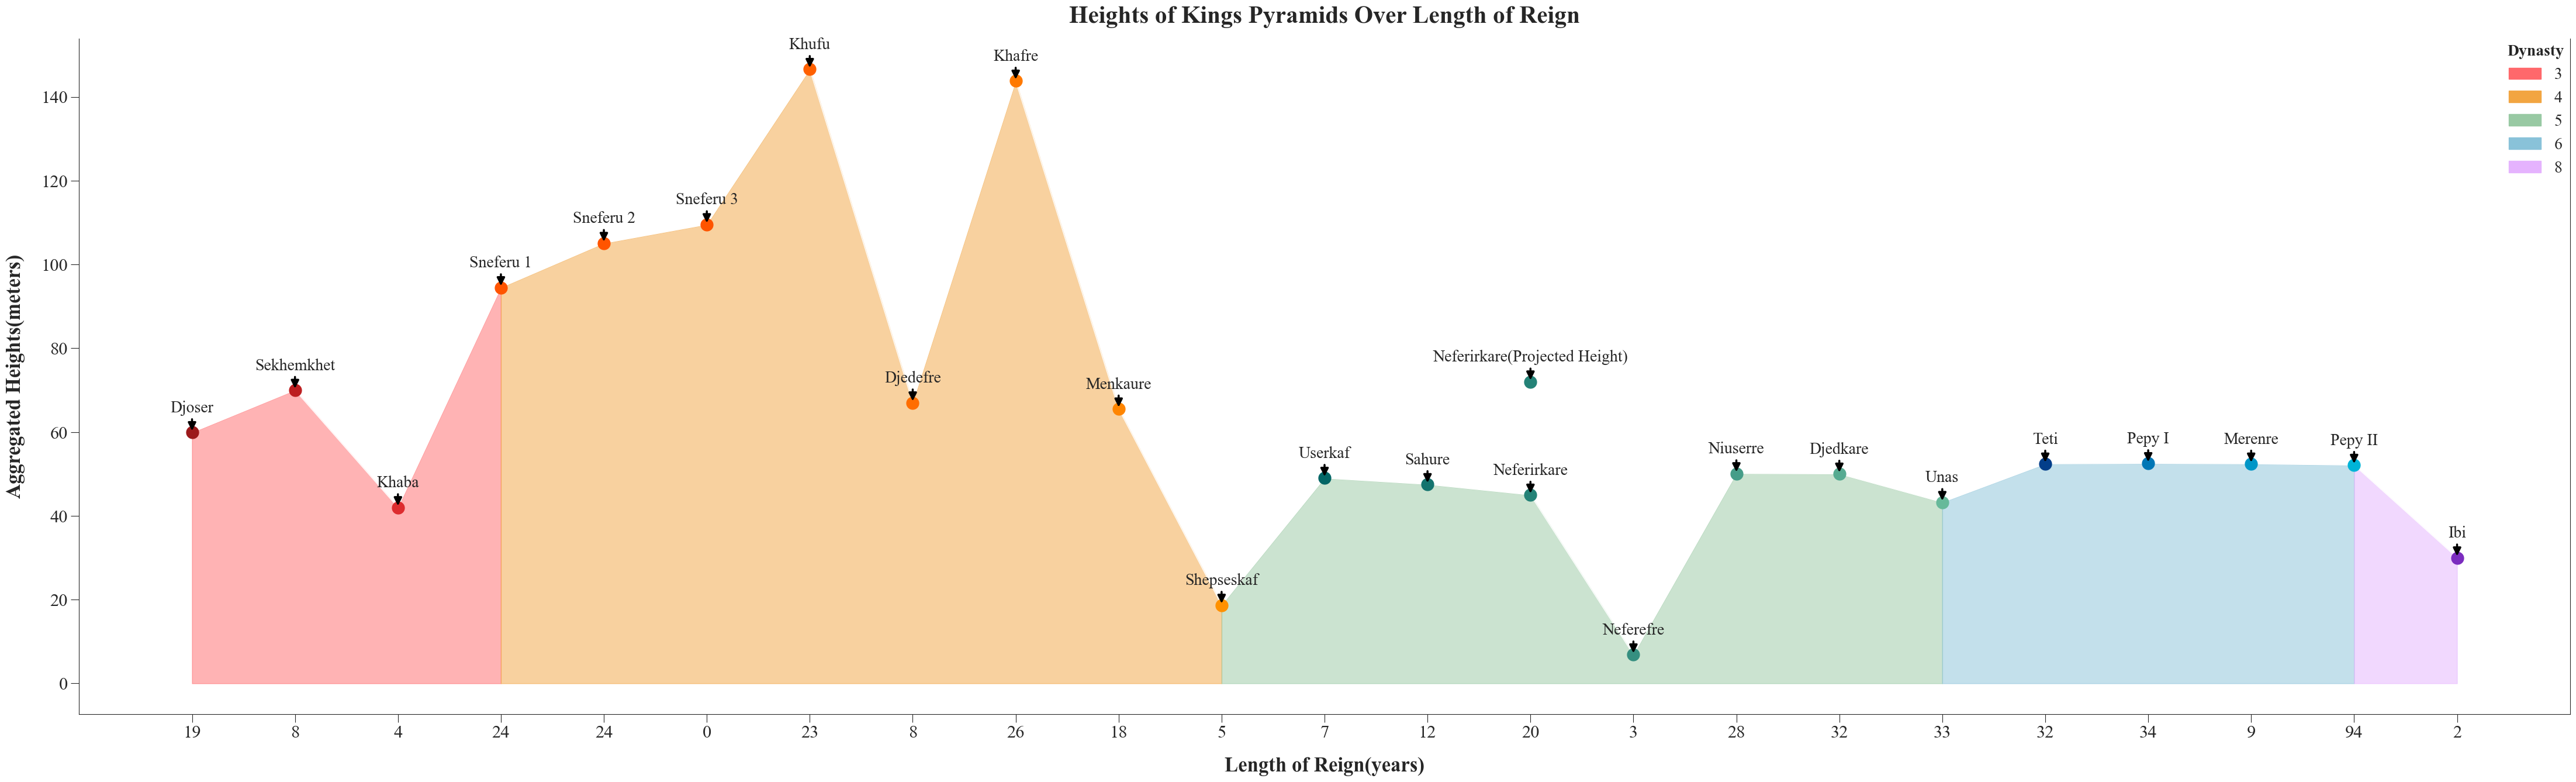

In [32]:

complex_heights_kings = complexes[['height', 'royal_status', 'pyramid_complex', 'length_of_reign','dynasty']][(complexes['royal_status'] == 'King') & (pd.notnull(complexes['height']))].reset_index(drop=True)
complex_reign_length = complex_heights_kings.groupby('pyramid_complex', sort=False, as_index=False)['length_of_reign'].sum()
complex_reign_length['length_of_reign'] = complex_reign_length['length_of_reign'].astype(int)
merged_kings_reign_df = pd.merge(complex_heights_kings, complex_reign_length, on=['pyramid_complex'], how='left')


merged_kings_reign_df.at[13, 'height'] = '44.98'
merged_kings_reign_df['height'] = pd.to_numeric(merged_kings_reign_df['height'])


plt.figure(figsize=(55, 15))
sns.set_style(style='ticks')
plt.rcParams['font.family'] = 'Times New Roman'
colors = ['#9c191b', '#bd1f21', '#dd2c2f', '#ff5400', '#ff5400', '#ff5400', '#ff6000', '#ff6d00', '#ff7900', '#ff8500', '#ff9100', '#036666', '#14746f', '#248277', '#358f80', '#469d89', '#56ab91', '#67b99a', '#023e8a', '#0077b6', '#0096c7', '#00b4d8', '#7b2cbf']

ax = sns.lineplot(x=range(len(merged_kings_reign_df)), y='height', data=merged_kings_reign_df, marker='o', color='white', linewidth=1.0)
ax.spines['top'].set_visible(False)


plt.xticks(ticks=range(len(merged_kings_reign_df)), labels=merged_kings_reign_df['length_of_reign_y'], fontsize=22)
plt.yticks(fontsize=22)
plt.tick_params(axis='both', which='major', length=10) 


for i, row in merged_kings_reign_df.iterrows():
    ax.plot(i, row['height'], 'o', color=colors[i % len(colors)], markersize=15)

fill_segments = [
    (0, 3, '#ff686b', '3'),  
    (3, 10, '#f2a541', '4'),  
    (10, 17, '#98c9a3', '5'), 
    (17, 21, '#89c2d9', '6'),  
    (21, 22, '#e5b3fe', '8')  
]

handles = []
labels = []

for start, end, color, label in fill_segments:
    ax.fill_between(range(start, end + 1), merged_kings_reign_df['height'][start:end + 1], color=color, alpha=0.5)
    handles.append(Patch(color=color, label=label))
    labels.append(label)

for i, row in merged_kings_reign_df.iterrows():
    x = i
    y = row['height']
    name = row['pyramid_complex']
    ax.annotate(
        f"{name}",
        xy=(x, y),
        xytext=(0, 25),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='-|>', lw=2.5),
        ha='center', fontsize=20
    )


neferirkare_index = merged_kings_reign_df[merged_kings_reign_df['pyramid_complex'] == 'Neferirkare'].index[0]
ax.plot(neferirkare_index, 72, 'o', color='#248277', markersize=15)  
ax.annotate(
    'Neferirkare(Projected Height)',
    xy=(neferirkare_index, 72),
    xytext=(0, 25),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='-|>', lw=2.5),
    ha='center', fontsize=20
)

legend = ax.legend(handles=handles, labels=labels, title='Dynasty', bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0., fontsize=20)
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')
plt.setp(legend.get_title(), fontweight='bold', fontsize=20)


plt.xlabel('Length of Reign')
ax.set_ylabel('Aggregated Heights(meters)', fontweight='bold', fontsize=25,labelpad=20)
ax.set_xlabel('Length of Reign(years)', fontweight='bold', fontsize=25,labelpad=20)
ax.set_title('Heights of Kings Pyramids Over Length of Reign', fontsize=30, fontweight='bold',pad=20)

plt.show()


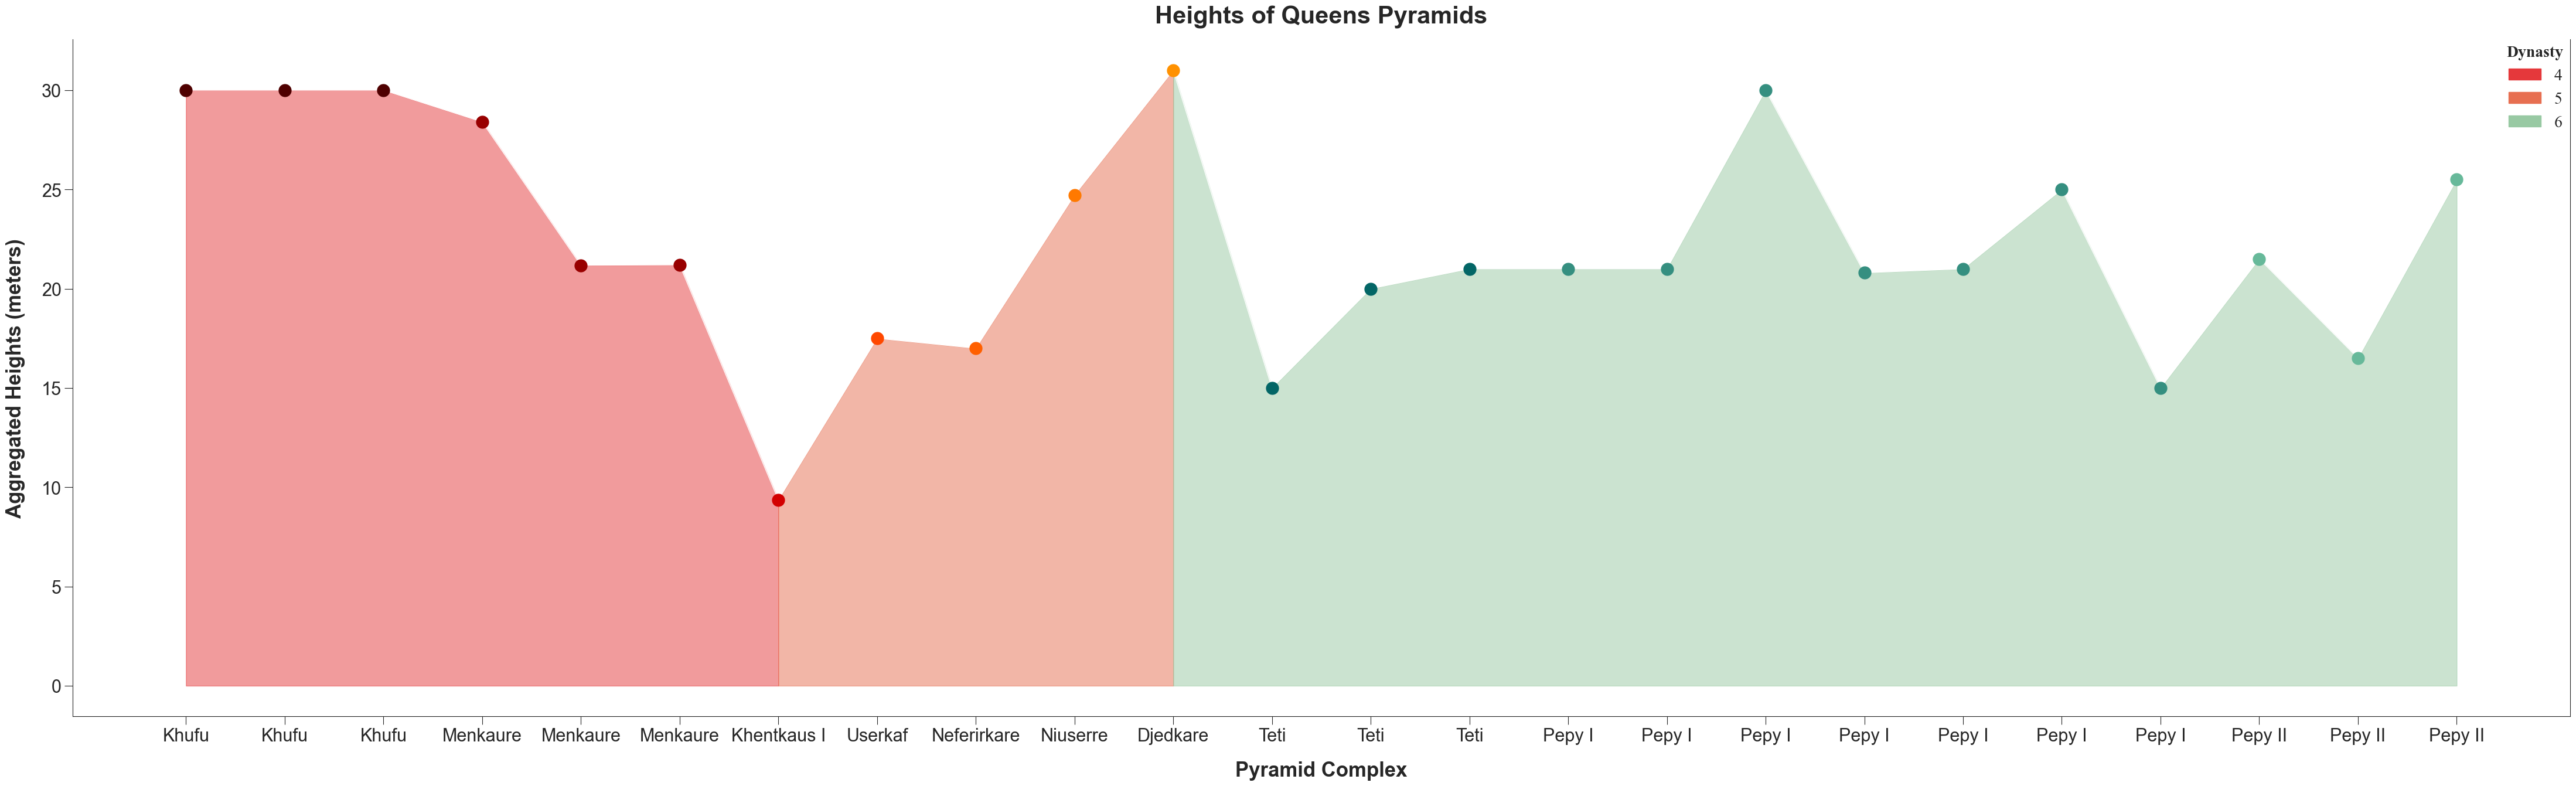

In [33]:

complex_heights_queens = complexes[['height', 'royal_status', 'pyramid_complex', 'dynasty']][(complexes['royal_status'] == 'Queen') & (pd.notnull(complexes['height']))][['height', 'pyramid_complex', 'dynasty','royal_status']].reset_index(drop=True)
complex_heights_queens.at[6, 'height'] = 9.365
complex_heights_queens.at[22, 'height'] = 16.5
complex_heights_queens['height'] = pd.to_numeric(complex_heights_queens['height'])



plt.figure(figsize=(55, 15))
sns.set_style(style='ticks')
plt.tick_params(axis='both', which='major', length=10) 
plt.rcParams['font.family'] = 'Times New Roman'

colors= ['#4f0000', '#4f0000', '#4f0000','#980000', '#980000', '#980000', '#d30000', '#ff4800','#ff6000',  '#ff7900', '#ff9100','#036666', '#036666', '#036666', '#358f80', '#358f80', '#358f80', '#358f80', '#358f80', '#358f80', '#358f80', '#67b99a', '#67b99a', '#67b99a' ]

ax = sns.lineplot(x=complex_heights_queens.index, y='height', data=complex_heights_queens, marker='o', color='white', linewidth=1.0)
for i, row in complex_heights_queens.iterrows():
    ax.plot(i, row['height'], 'o', color=colors[i % len(colors)], markersize=15)

plt.xticks(ticks=range(len(complex_heights_queens)), labels=complex_heights_queens['pyramid_complex'], fontsize=22, rotation=0)
plt.yticks(fontsize=22)
ax.spines['top'].set_visible(False)

handles = []
labels = []

fill_segments = [
    (0, 6, '#e5383b', '4'),
    (6, 10, '#e76f51', '5'),
    (10, 23, '#98c9a3', '6'),
]

for start, end, color, label in fill_segments:
    ax.fill_between(complex_heights_queens.index[start:end + 1], complex_heights_queens['height'][start:end + 1], color=color, alpha=0.5)
    handles.append(Patch(color=color, label=label))
    labels.append(label)

legend = ax.legend(handles=handles, labels=labels, title='Dynasty', bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0., fontsize=20)
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')
plt.setp(legend.get_title(), fontweight='bold', fontsize=20)


plt.xlabel('Pyramid Complex')
ax.set_ylabel('Aggregated Heights (meters)', fontweight='bold', fontsize=25,labelpad=20)
ax.set_xlabel('Pyramid Complex', fontweight='bold', fontsize=25,labelpad=20)
ax.set_title('Heights of Queens Pyramids', fontsize=30, fontweight='bold', pad=20)  # Increase pad to move title higher

plt.show()


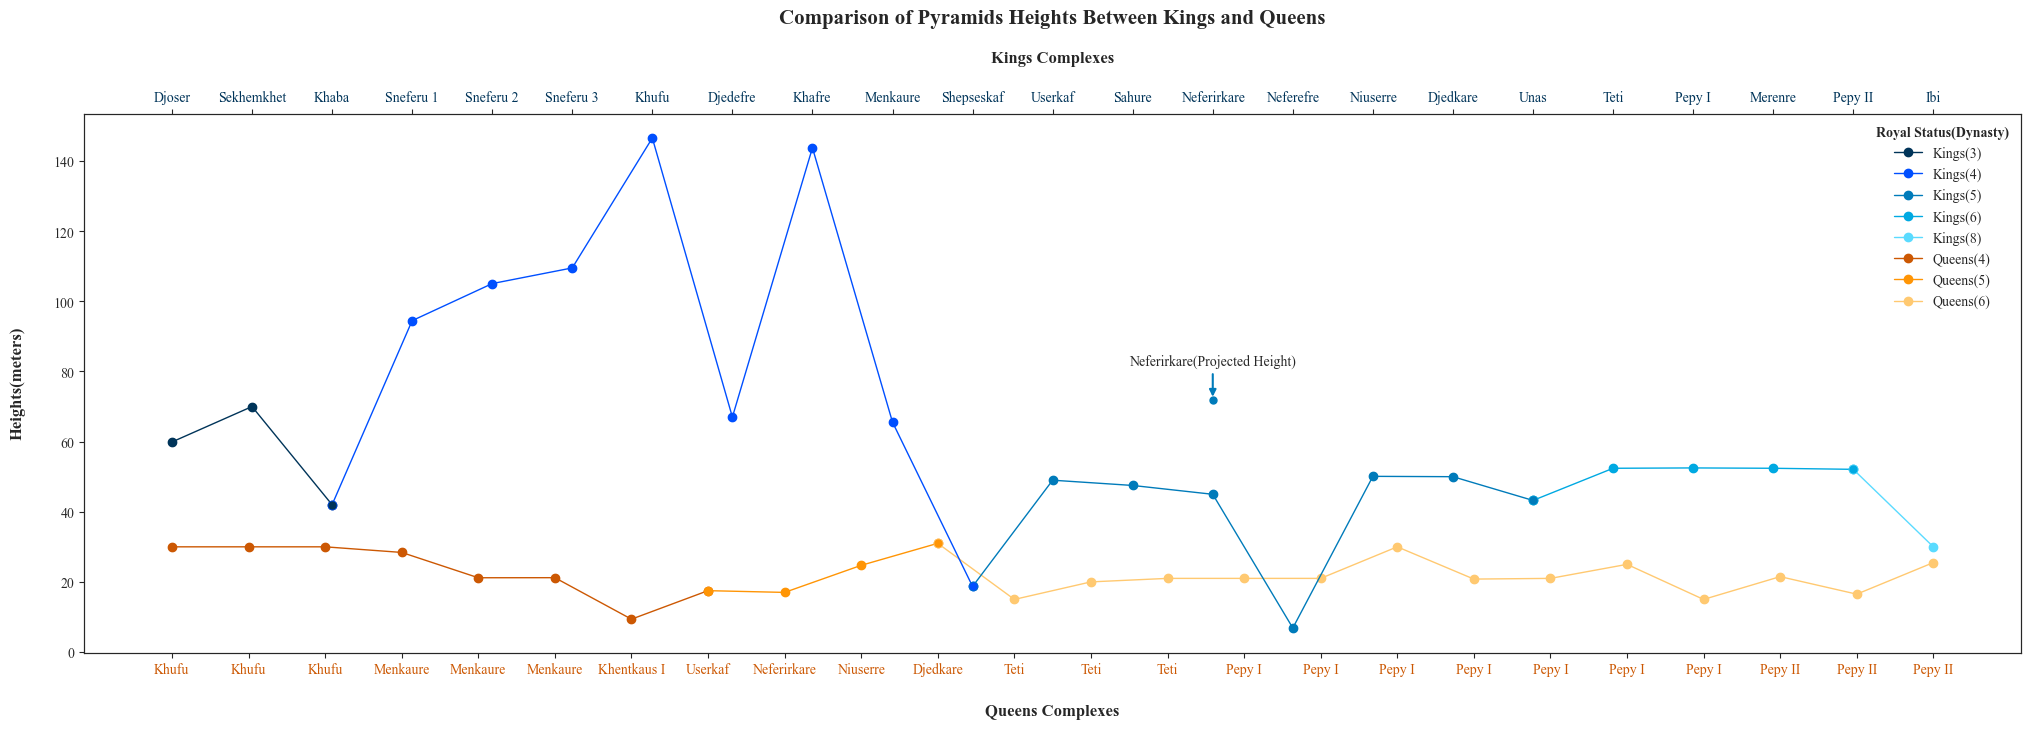

In [7]:

fig, ax1 = plt.subplots(figsize=(25, 7))
plt.rcParams['font.family'] = 'Times New Roman'
ax1.plot(range(8), complex_heights_queens['height'][:8], marker='o', color='#cc5803', linewidth=1.0, label='Queens(4)')
ax1.plot(range(7, 11), complex_heights_queens['height'][7:11], marker='o', color='#ff9505', linewidth=1.0, label='Queens(5)')
ax1.plot(range(10, len(complex_heights_queens)), complex_heights_queens['height'][10:], marker='o', color='#ffc971', linewidth=1.0, label='Queens(6)')
ax1.set_xticks(range(len(complex_heights_queens)))
ax1.set_xticklabels(complex_heights_queens['pyramid_complex'], fontsize=10, rotation=0,color='#cc5803')
ax1.set_xlabel('Queens Complexes',fontweight='bold',fontsize=12,labelpad=20)
ax1.set_ylabel('Heights(meters)',labelpad=20,fontweight='bold',fontsize=12)
ax1.tick_params(axis='x', rotation=0)
queens_colors= ['#cc5803', '#cc5803', '#cc5803','#cc5803','#cc5803', '#cc5803', '#cc5803', '#ff9505','#ff9505',  '#ff9505', '#ff9505','#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971', '#ffc971' ]
for i, row in complex_heights_queens.iterrows():
    ax1.plot(i, row['height'], 'o', color=queens_colors[i % len(queens_colors)], markersize=5)
    
ax2 = ax1.twiny()
ax2.plot(range(3),  merged_kings_reign_df['height'][:3], marker='o', color='#003459', linewidth=1.0, label='Kings(3)')
ax2.plot(range(2,11), merged_kings_reign_df['height'][2:11], marker='o', color='#004fff', linewidth=1.0, label='Kings(4)')
ax2.plot(range(10,18), merged_kings_reign_df['height'][10:18], marker='o', color='#007bba', linewidth=1.0, label='Kings(5)')
ax2.plot(range(17,22), merged_kings_reign_df['height'][17:22], marker='o', color='#00a9e2', linewidth=1.0, label='Kings(6)')
ax2.plot(range(21,len(merged_kings_reign_df)), merged_kings_reign_df['height'][21:], marker='o', color='#5adbff', linewidth=1.0, label='Kings(8)')
ax2.set_xticks(range(len(merged_kings_reign_df)))
ax2.set_xticklabels(merged_kings_reign_df['pyramid_complex'], fontsize=10, rotation=0, color='#003459')
ax2.set_xlabel('Kings Complexes',labelpad=20,fontweight='bold',fontsize=12)
ax2.tick_params(axis='x', rotation=0)
ax2.set_title('Comparison of Pyramids Heights Between Kings and Queens',pad=20, fontweight='bold',fontsize=15)
kings_colors= ['#003459', '#003459', '#003459','#004fff', '#004fff', '#004fff', '#004fff', '#004fff','#004fff',  '#004fff', '#004fff','#007bba', '#007bba', '#007bba', '#007bba', '#007bba','#007bba', '#007bba', '#00a9e2', '#00a9e2', '#00a9e2', '#00a9e2', '#5adbff' ]
for i, row in merged_kings_reign_df.iterrows():
    ax2.plot(i, row['height'], 'o', color=kings_colors[i % len(kings_colors)], markersize=5)
neferirkare_index = merged_kings_reign_df[merged_kings_reign_df['pyramid_complex'] == 'Neferirkare'].index[0]
ax2.plot(neferirkare_index, 72, 'o', color='#007bba', markersize=5)  
ax2.annotate(
    'Neferirkare(Projected Height)',
    xy=(neferirkare_index, 72),
    xytext=(0, 25),
    textcoords='offset points',
    arrowprops=dict(facecolor='#007bba', edgecolor='#007bba', arrowstyle='-|>', lw=1.5),
    ha='center', fontsize=10
)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend=ax1.legend(lines2 + lines1, labels2 + labels1, loc='upper right',title='Royal Status(Dynasty)')
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')
plt.setp(legend.get_title(), fontweight='bold', fontsize=10)

plt.show()


In [26]:
complex_cities=complexes[['site_or_location','casing','superstructure_type','royal_status']]
complex_cities = complexes.groupby('site_or_location', sort=False).agg(
    casing=('casing', lambda x: list(set(x))),
    complex_count=('site_or_location', 'count'),
    superstructure=('superstructure_type', lambda x: list(set(x))),
    kings_count=('royal_status', lambda x: sum(x == 'King')),
    queens_count=('royal_status', lambda x: sum(x == 'Queen'))
).reset_index()
complex_cities['country']=['Egypt']*9
key = '91fc143d65da4b8ba69d53e153d0fdef'
geocoder = OpenCageGeocode(key)
def geocode_address(row):
    location = geocoder.geocode(f"{row['site_or_location']},{row['country']}")
    if location and len(location):
        return location[0]['geometry']['lat'], location[0]['geometry']['lng']
    else:
        return None, None
complex_cities['Latitude'], complex_cities['Longitude'] = zip(*complex_cities.apply(geocode_address, axis=1))

complex_cities


,site_or_location,casing,complex_count,superstructure,kings_count,queens_count,country,Latitude,Longitude
0,Saqqara,[Limestone],10,[Pyramid],6,4,Egypt,29.850335,31.228284
1,Zawiyet el-Aryan,[Unknown],2,[Pyramid],2,0,Egypt,27.000000,30.000000
2,Meidum,[Limestone],1,[Pyramid],1,0,Egypt,29.388371,31.157128
3,Dahshur,[Limestone],2,[Pyramid],2,0,Egypt,29.751277,31.240815
4,Giza,"[Limestone, Granite, Not Cased, Limestone]",10,[Pyramid],3,7,Egypt,29.987075,31.211806
5,Abu Roash,"[Limestone, Granite]",1,[Pyramid],1,0,Egypt,30.044480,31.092690
6,South Saqqara,"[Limestone, Limestone, Granite]",9,"[Mastaba, Pyramid]",5,4,Egypt,29.840128,31.213759
7,Abusir,[Limestone],6,[Pyramid],4,2,Egypt,29.898159,31.208420
8,North Saqqara,"[nan, Unknown, Limestone]",12,"[Pyramid, Pyramid?]",1,11,Egypt,29.850000,31.216670


In [31]:


map_center = complex_cities['Latitude'].mean(), complex_cities['Longitude'].mean()
sites_map = folium.Map(location=map_center, zoom_start=7) 

for index, row in complex_cities.iterrows():
    if row['Latitude'] and row['Longitude']:
        if 'Saqqara' in row['site_or_location']:
            color = 'pink'
        elif row['site_or_location'] == 'Zawiyet el-Aryan':
            color = 'red'
        elif row['site_or_location'] == 'Meidum':
            color = 'green'
        elif row['site_or_location'] == 'Dahshur':
            color = 'lightblue'
        elif row['site_or_location'] == 'Giza':
            color = 'blue'
        elif row['site_or_location'] == 'Abu Roash':
            color = 'purple'
        else:
            color = 'orange'
        popup_text = f"Site:<br> {row['site_or_location']}<br><br>Number of Complexes:<br> {row['complex_count']}<br><br>Superstructure Type:<br> {row['superstructure']}<br><br>Kings Count:<br> {row['kings_count']}<br><br>Queens Count:<br> {row['queens_count']}"
        folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text,icon=folium.Icon(color=color)).add_to(sites_map)

sites_map



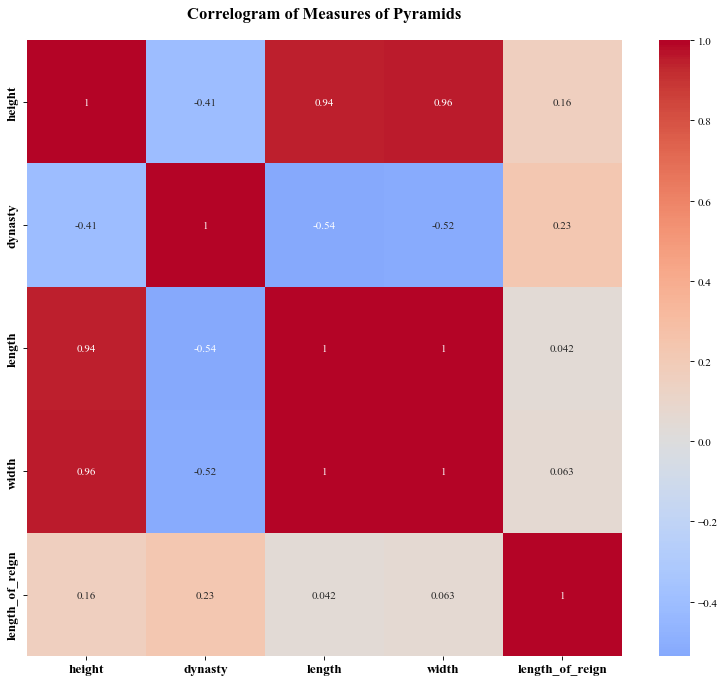

In [5]:
complex_heights = complexes[['height', 'dynasty','length','width','length_of_reign']][(pd.notnull(complexes['height']))]
complex_heights.at[22, 'height'] = '72'
complex_heights.at[18, 'height'] = 9.365
complex_heights.at[50, 'height'] = 16.5
complex_heights['height'] = pd.to_numeric(complex_heights['height'])
complex_heights['length_of_reign'] = pd.to_numeric(complex_heights['length_of_reign'])

plt.figure(figsize=(12,10), dpi= 80)
plt.rcParams['font.family'] = 'Times New Roman'
sns.heatmap(complex_heights.corr(), xticklabels=complex_heights.corr().columns, yticklabels=complex_heights.corr().columns, cmap='coolwarm', center=0, annot=True)


plt.title('Correlogram of Measures of Pyramids', fontsize=15,pad=20,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.show()


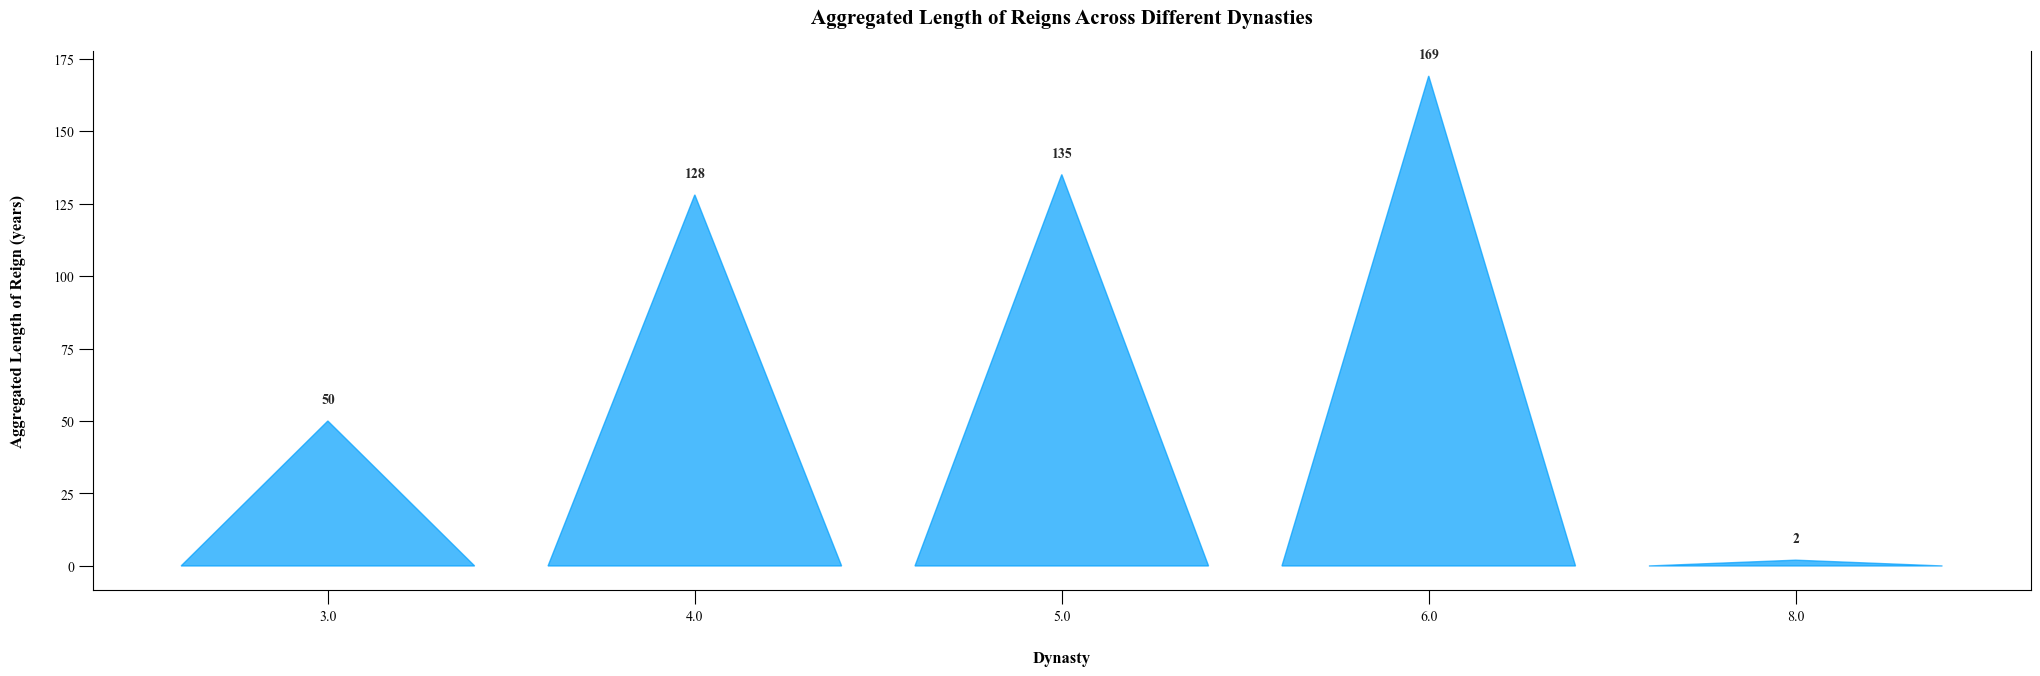

In [6]:
dynasties_length_of_reign = complexes.groupby('dynasty')['length_of_reign'].sum().reset_index()
dynasties_length_of_reign['length_of_reign']=dynasties_length_of_reign['length_of_reign'].astype(int)
fig, ax = plt.subplots(figsize=(25, 7))
sns.set_style(style='ticks')
plt.tick_params(axis='both', which='major', length=10) 
plt.rcParams['font.family'] = 'Times New Roman'
for i, (category, value) in enumerate(zip(dynasties_length_of_reign['dynasty'].to_list(), dynasties_length_of_reign['length_of_reign'].to_list())):
    ax.fill([i-0.4, i, i+0.4], [0, value, 0], color='#009ffd', alpha=0.7)
    ax.text(i, value + 5, f'{value}', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.set_xticks(range(len(dynasties_length_of_reign['dynasty'].to_list())))
ax.set_xticklabels(dynasties_length_of_reign['dynasty'].to_list())
plt.title('Aggregated Length of Reigns Across Different Dynasties',fontweight='bold',pad=20, fontsize=15)
plt.xlabel('Dynasty',fontweight='bold',labelpad=20, fontsize=12)
plt.ylabel('Aggregated Length of Reign (years)', fontweight='bold',labelpad=20, fontsize=12)
ax.spines['top'].set_visible(False)
plt.show()


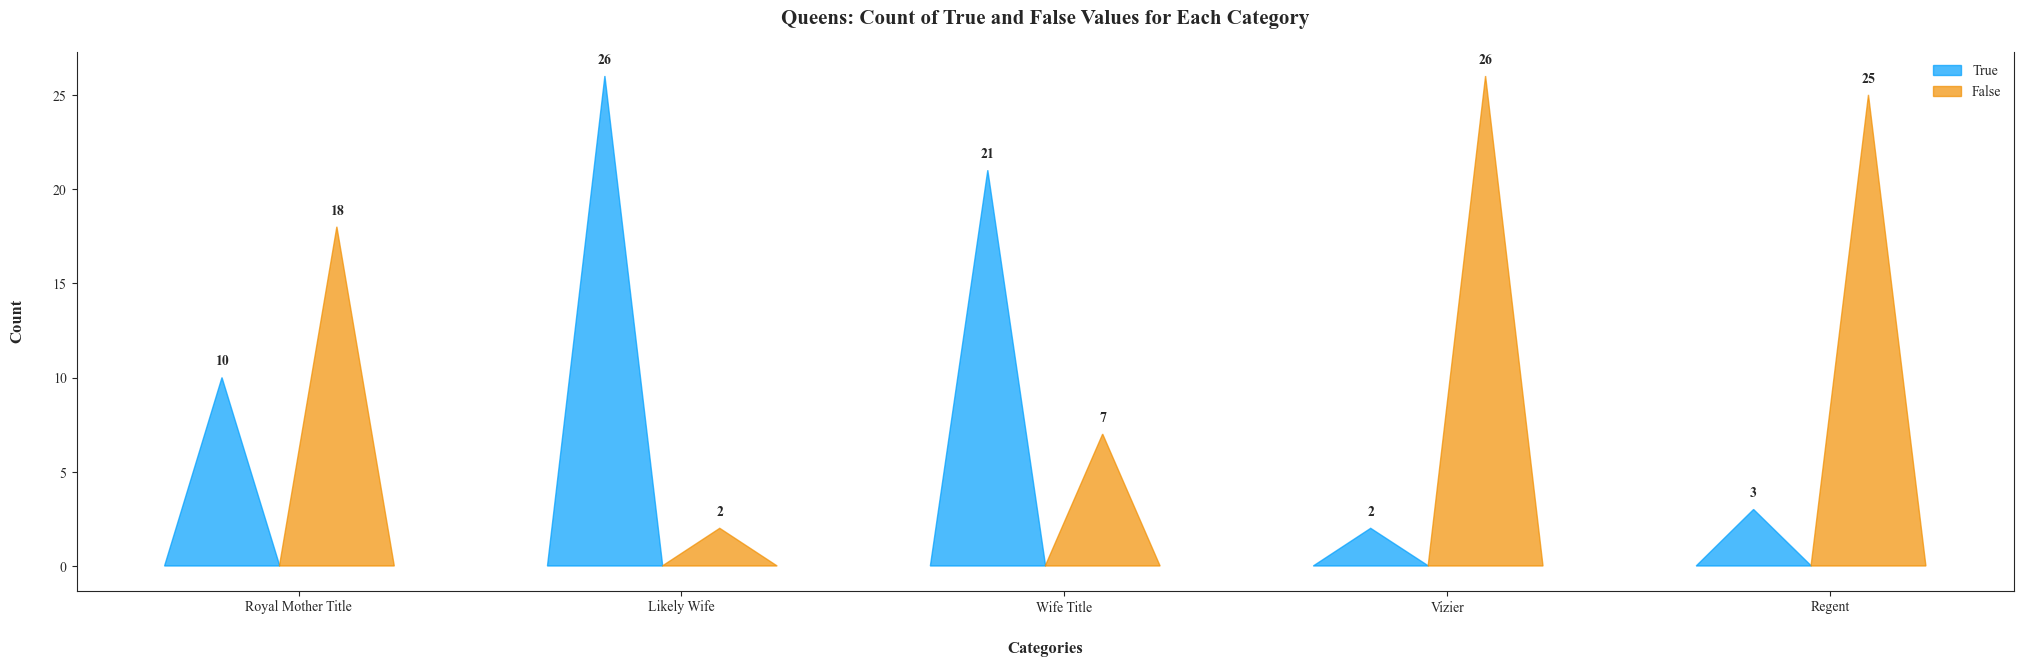

In [39]:

queens_status=df[['royal_mother_title','likely_wife','wife_title','vizier','regent','royal_status']][(df['royal_status'] == 'Queen')].drop(columns=['royal_status']).reset_index(drop=True)
queens_status = queens_status.map(lambda x: str(x))
queens_status_true_false = queens_status.apply(lambda x: x.value_counts()).transpose().fillna(0)

plt.figure(figsize=(25, 7))
plt.rcParams['font.family'] = 'Times New Roman'
ax = plt.gca()

colors = {'True': '#009ffd', 'False': '#f18f01'}

for i, column in enumerate(queens_status_true_false.index):
    true_count = queens_status_true_false.at[column, 'True'] if 'True' in queens_status_true_false.columns else 0
    false_count = queens_status_true_false.at[column, 'False'] if 'False' in queens_status_true_false.columns else 0
    
    # 'True'
    ax.fill([i - 0.15, i, i + 0.151], [0, true_count, 0], color=colors['True'], alpha=0.7, label='True' if i == 0 else "")
    ax.text(i, true_count + 0.5, f'{true_count}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 'False
    ax.fill([i + 0.15, i + 0.3, i + 0.45], [0, false_count, 0], color=colors['False'], alpha=0.7, label='False' if i == 0 else "")
    ax.text(i + 0.3, false_count + 0.5, f'{false_count}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks([i + 0.2 for i in range(len(queens_status_true_false.index))])
ax.set_xticklabels(['Royal Mother Title', 'Likely Wife', 'Wife Title', 'Vizier', 'Regent'])

plt.xlabel('Categories', fontsize=12,fontweight='bold',labelpad=20)
plt.ylabel('Count', fontsize=12,fontweight='bold',labelpad=20)
plt.title('Queens: Count of True and False Values for Each Category', fontsize=15,fontweight='bold',pad=20)
plt.xticks(rotation=0)
ax.spines['top'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
legend=ax.legend(handles[:2], labels[:2])
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')

plt.show()


In [9]:
# Exporting to HTML
from jinja2 import Template

output_html_path = r'../pages/index.html'
input_template_path = r'../templates/template.html'

plotly_jinja_data = {
    'grouped_heights':grouped_heights_fig.to_html(full_html=False),
    'dynasty_count':dynasty_count_fig.to_html(full_html=False),
    'confirmed_count':confirmed_count_fig.to_html(full_html=False),
    'line_heights':line_heights_fig.to_html(full_html=False)
}

with open(output_html_path, 'w', encoding='utf-8') as out:
    with open(input_template_path) as template:
        j2_template = Template(template.read())
        out.write(j2_template.render(plotly_jinja_data))

NameError: name 'grouped_heights_fig' is not defined